# Decision Tree Lab

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import math
import matplotlib.pyplot as plt

# example of a ordinal encoding
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

## 1. Implement the ID3 decision tree algorithm  
- Use standard information gain as your basic attribute evaluation metric.  Note that ID3 would usually augment information gain with a mechanism to penalize statistically insignificant attribute splits to avoid overfit (e.g. early stopping, gain ratio, etc.)
- Include the ability to handle unknown attributes by making "unknown" a separate output class.
- You do not need to handle real valued attributes.
- You are welcome to create other classes and/or functions in addition to the ones provided below. (e.g. If you build out a tree structure, you might create a node class).
- It is a good idea to use simple data sets (like the lenses data and the pizza homework), which you can check by hand, to test each detailed step of your algorithm to make sure it works correctly. 

In [ ]:
import copy
class TreeNode():
  def __init__(self, attribute_label, class_label, isRoot, num_instances, prev_node, output_sums, attributes, atr_list, class_list):
    self.attribute_label = attribute_label
    self.class_label = class_label
    self.isRoot = isRoot
    self.num_instances = num_instances
    self.prev_node = prev_node
    self.output_sums= output_sums
    self.attributes = attributes
    self.atr_list = atr_list
    self.class_list= class_list
    self.info = self.CalculateInfo()
    self.prediction = np.argmax(output_sums)
    self.nextNode = None

  def CalculateInfo(self):
    info = 0
    for out_cls in range(len(self.output_sums)):
      # print(f"Class {self.class_label} sums = {self.output_sums}")
      if self.output_sums[out_cls] != 0:
        info += (-self.output_sums[out_cls]/self.num_instances) * np.log2(self.output_sums[out_cls]/self.num_instances)
        # print(f"Output Instances = {self.output_sums[out_cls]} total instances: {self.num_instances}")
    if not self.isRoot:
      info = (self.num_instances/self.prev_node.num_instances) * info
    #   print(f"Penalty: {self.num_instances}/{self.prev_node.num_instances}")
    # print(f"Partial Info = {info} on attribute {self.attribute_label} and class {self.output_sums[out_cls]}")
    return info

  def FixInfo(self):
    if self.num_instances > 0:
      self.info = self.info * (self.prev_node.num_instances/self.num_instances)
    return self

  def SetNextNode(self, node):
    self.nextNode = node
      



class DTClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self,counts=None):
        """ Initialize class with chosen hyperparameters.
        Args:
        Optional Args (Args we think will make your life easier):
            counts: A list of Ints that tell you how many types of each feature there are
        Example:
            DT  = DTClassifier()
            or
            DT = DTClassifier(count = [2,3,2,2])
            Dataset = 
            [[0,1,0,0],
            [1,2,1,1],
            [0,1,1,0],
            [1,2,0,1],
            [0,0,1,1]]

        """
        self.counts = counts

    def getAttributeLabel(self, encoded_label, label_list):
      label = label_list[encoded_label]
      return label
    
    def getClassLabel(self, encoded_label, label_column):
      label_set = set()
      label = ''
      for i in label_column:
        label_set.add(i)
      label_set = sorted(label_set)
      cntr = 0
      for x in label_set:
        if cntr == encoded_label:
          label = x
        cntr += 1
      return label


    def print_tree(self, attribute_list):
      info_copy = copy.deepcopy(self.info_gains)
      node = self.root
      layer = node.nextNode
      # print(layer)
      tree_list = [node]
      indent = 0
      prev_indent = None
      while tree_list:
        # print(tree_list)
        attribute_label = self.getAttributeLabel(node.attribute_label, attribute_list)
        class_label = self.getClassLabel(node.class_label, self.X[:,node.attribute_label])
        attribute_label = '     ' * indent + attribute_label
        print(f'{attribute_label} = {class_label}: {"" if not node.prev_node or node.isRoot else info_copy[node.prev_node.nextNode - 1]}')
        if  node.prev_node or not node.isRoot:
          info_copy[node.prev_node.nextNode - 1] = " "
        tree_list.remove(node)
        indent += 1
        if layer:
          prev_indent = indent -1
          for tnode in reversed(self.tree[layer]):
            tree_list.insert(0, tnode)
        elif not tree_list or tree_list[0].attribute_label == node.attribute_label or indent - 1 <= prev_indent:
          prediction = self.getClassLabel(node.prediction, y)
          print(f"{'      ' * indent}predicition = {prediction}")
          if tree_list and tree_list[0].attribute_label == node.attribute_label:
            indent -= 1
            prev_indent = indent
          else:
            prev_indent -= 1
            indent -= 2
            
        else:
          prev_indent = indent -1
          indent -= 2
        # print(tree_list)
        if tree_list:
          node = tree_list[0]
          layer = node.nextNode

      return

    def fit(self, X, y):
        """ Fit the data; Make the Decision tree

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 1D numpy array with the training targets

        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        self.X = X
        num_rows, num_cols = X.shape
        attributes = [item for item in range(num_cols)]
        finished = False

        encoder = OrdinalEncoder()
        encoded_X = encoder.fit_transform(X)
        encoded_y = encoder.fit_transform(y.reshape(-1,1))

        output_classes = self.counts[-1]
        tree = []
        splits = []
        info_gain_splits = []

        # INSTANTIATE ROOT NODE

        output_sums = [0] * output_classes
        for index in encoded_y:
          output_sums[int(index[0])] += 1
        self.root = TreeNode(-1, -1, True, num_rows, None, output_sums, attributes, [], [])
        tree.append([self.root])

        self.info_gains = []
        cntr = 0 
        while not finished:
          if len(tree) - 1 < cntr:
            finished = True
          else:
            for node in tree[cntr]:
              gain = 0
              tree_additions = []
              row_instances = np.where(encoded_X)
              updated_X = encoded_X.copy()
              updated_y = encoded_y.copy()
              # print(node.atr_list)
              for i in range(len(node.atr_list)):
                row_instances = np.where(updated_X[:,node.atr_list[i]] == node.class_list[i])[0]
                empty_list = []
                y_list = []
                for row in row_instances:
                  empty_list.append(updated_X[row])
                  y_list.append(updated_y[row])
                updated_X = empty_list.copy()
                updated_X = np.array(updated_X)
                updated_y = y_list.copy()
                updated_y = np.array(updated_y)
                # print(f"Rows where atr {node.atr_list[i]} =  cls {node.class_list[i]} : {updated_X}")
              if node.attributes  or node.attributes is not None:
                for atr in node.attributes:
                  node_list = []
                  info = 0
                  for cls in range(self.counts[atr]):
                    # print(atr, cls)
                    # print(updated_X)
                    if updated_X.any():
                      row_instances = np.where(updated_X[:,atr] == cls)[0] 
                    else:
                      continue
                    # print(f"Number of instances where {atr} = {cls} for node {node.attribute_label}: {len(row_instances)} {row_instances}")
                    out_sums = [0] * output_classes
                    for row in row_instances:
                      out_sums[int(updated_y[row][0])] += 1
                    list_to_pass = node.attributes.copy()
                    list_to_pass.remove(atr)
                    list_of_atr = node.atr_list.copy()
                    list_of_atr.append(atr)
                    list_of_cls = node.class_list.copy()
                    list_of_cls.append(cls)
                    attribute_node = TreeNode(atr, cls, False,len(row_instances), node,out_sums, list_to_pass,list_of_atr, list_of_cls)
                    info += attribute_node.info
                    node_list.append(attribute_node.FixInfo())
                  # print(f"info: {info} for atrribute {atr}")
                  if node.info - info > gain:
                    tree_additions = node_list
                    gain = node.info-info

              if tree_additions:
                self.info_gains.append(gain)
                tree.append(tree_additions)
                node.SetNextNode(len(tree) - 1)

            
            cntr += 1

        self.tree = tree
        return self

    def predict(self, X):
        """ Predict all classes for a dataset X

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets

        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        encoder = OrdinalEncoder()
        encoded_X = encoder.fit_transform(X)


        predictions = []
        num_rows, num_cols = X.shape
        for row in range(num_rows):
          layer = 0
          prev_layer = 0
          while layer is not None:
            # print(f"layer is: {layer}")
            if self.tree[layer][0].attribute_label == -1:
              layer += 1
              continue
            else:
              attribute = self.tree[layer][0].attribute_label
              feature_class = encoded_X[row][attribute]
              # print(f"Attribute: {attribute} and Class = {feature_class}")
              # print(f"Layer should be: {layer + 1} + {feature_class}")
              prev_layer = layer
              layer = self.tree[prev_layer][int(feature_class)].nextNode
          # print(f"final attribute: {attribute} and class {feature_class}")
          # print(self.tree[prev_layer][int(feature_class)].output_sums)
          predictions.append(self.tree[prev_layer][int(feature_class)].prediction)

        return predictions


    def score(self, X, y):
        """ Return accuracy(Classification Acc) of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 1D numpy array of the targets 
        """
        encoder = OrdinalEncoder()

        y_hat = self.predict(X)
        encoded_y = encoder.fit_transform(y.reshape(-1,1))



        score = accuracy_score(encoded_y, y_hat)
        return score
      



### 1.1 (20%) Debug 

- Debug your model by training on the lenses dataset: [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff)
- Test your model on the lenses test set: [Debug Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff)
- Parameters:
For this problem the number of unique feature values for each feature is: counts = [3,2,2,2] (You should compute this when you read in the data, before fitting)
---

Expected Results: Accuracy = [0.33]

Information gain at splits = [0.5487949406953987, 0.7704260414863775, 0.3166890883150208, 1.0, 0.4591479170272447, 0.9182958340544894]

Predictions should match this file: [Lenses Predictions](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv)

*NOTE: The [Lenses Prediction](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv) uses the following encoding: soft=2, hard=0, none=1. Use this same encoding.*

<!-- You should be able to get about 68% (61%-82%) predictive accuracy on the lenses data -->

Here's what your decision tree splits and information gains should look like, with the corresponding child node predictions:

<pre>
tear_prod_rate = normal: 0.5487949406953987
    astigmatism = no: 0.7704260414863775
        age = pre_presbyopic: 0.3166890883150208
            prediction: soft
        age = presbyopic:
            spectacle_prescrip = hypermetrope: 1.0
                prediction: soft
            spectacle_prescrip = myope:
                prediction: none
        age = young:
            prediction: soft
    astigmatism = yes:
        spectacle_prescrip = hypermetrope: 0.4591479170272447
            age = pre_presbyopic: 0.9182958340544894
                prediction: none
            age = presbyopic:
                prediction: none
            age = young:
                prediction: hard
        spectacle_prescrip = myope:
            prediction: hard
tear_prod_rate = reduced:
    prediction: none
</pre>

In [ ]:
# Load debug training data 
# Train Decision Tree
# Load debug test data
# Execute and print the model accuracy and the information gain of every split you make


from scipy.io import arff
import pandas as pd

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff --output lenses.arff

train_data_unclean = arff.loadarff('lenses.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0])
lenses_np_data = train_data_from_scipy.to_numpy()


train_data_split= np.hsplit(lenses_np_data, [4])
X = train_data_split[0]
y = np.array(train_data_split[1].reshape(1,-1)[0])

clf =  DTClassifier(counts=[3,2,2,2,3])
clf.fit(X,y)
print(clf.info_gains)


[0.5487949406953982, 0.7704260414863778, 0.3166890883150208, 0.4591479170272448, 1.0, 0.9182958340544896]


In [ ]:
clf.print_tree(["age", "spectacle_prescrip", "astigmatism", "tear_prod_rate", "root"])

root = : 
     tear_prod_rate = b'normal': 0.5487949406953982
          astigmatism = b'no': 0.7704260414863778
               age = b'pre_presbyopic': 0.3166890883150208
                        predicition = b'soft'
               age = b'presbyopic':  
                    spectacle_prescrip = b'hypermetrope': 1.0
                              predicition = b'soft'
                    spectacle_prescrip = b'myope':  
                              predicition = b'none'
               age = b'young':  
                        predicition = b'soft'
          astigmatism = b'yes':  
               spectacle_prescrip = b'hypermetrope': 0.4591479170272448
                    age = b'pre_presbyopic': 0.9182958340544896
                              predicition = b'none'
                    age = b'presbyopic':  
                              predicition = b'none'
                    age = b'young':  
                              predicition = b'hard'
               spectacle_prescrip = b'my

In [ ]:
# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff --output lenses_test.arff

test_data_unclean = arff.loadarff('lenses_test.arff')
test_data_from_scipy = pd.DataFrame(test_data_unclean[0])
lenses_test_np_data = test_data_from_scipy.to_numpy()


test_data_split= np.hsplit(lenses_test_np_data, [4])
X_test = test_data_split[0]
y_test = np.array(test_data_split[1].reshape(1,-1)[0])

clf.score(X_test, y_test)


0.3333333333333333

I was able to get the same splits and accuracy as the debug dataset. My splits are in a diiferent order, I think I just traveresed the tree in a different order than the debug set. But the info gains are the same, and the tree looks the same. Just a inorder vs. pre order traversal.

In [ ]:
# Optional Debugging Dataset - Pizza Homework
# pizza_dataset = np.array([[1,2,0],[0,0,0],[0,1,1],[1,1,1],[1,0,0],[1,0,1],[0,2,1],[1,0,0],[0,2,0]])
# pizza_labels = np.array([2,0,1,2,1,2,1,1,0])

### 1.2 (20%) Evaluation 

- We will evaluate your model based on its performance on the zoo dataset. 
- Train your model using this dataset: [Evaluation Train Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff)
- Test your model on this dataset: [Evaluation Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff)
- Parameters: counts = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2] (You should compute this when you read in the data, before fitting)
---
Your progam should print out your accuracy on the evaluation test dataset and also the information gain of each split you make.

In [ ]:
# Load evaluation training data
# Train Decision Tree
# Load evaluation test data
# Execute and print the model accuracy and the information gain of every split you make
from scipy.io import arff
import pandas as pd

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff --output zoo.arff

train_data_unclean = arff.loadarff('zoo.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0])
zoo_np_data = train_data_from_scipy.to_numpy()


train_data_split= np.hsplit(zoo_np_data, [16])
X = train_data_split[0]
y = np.array(train_data_split[1].reshape(1,-1)[0])

clf =  DTClassifier(counts=[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 7])
clf.fit(X,y)
print(clf.info_gains)

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff --output zoo_test.arff

test_data_unclean = arff.loadarff('zoo_test.arff')
test_data_from_scipy = pd.DataFrame(test_data_unclean[0])
zoo_test_np_data = test_data_from_scipy.to_numpy()


test_data_split= np.hsplit(zoo_test_np_data, [16])
X_test = test_data_split[0]
y_test = np.array(test_data_split[1].reshape(1,-1)[0])

clf.score(X_test, y_test)

[1.3630469031539394, 0.8865408928220899, 0.8256265261578956, 0.6892019851173656, 0.7219280948873623, 0.9852281360342515, 0.6962122601251459, 0.8631205685666308, 0.7219280948873623]


0.147

Potentially similar to the debug dataset, I assume that all of the info gains are correct, but may be out of order because of the traversal of the tree. The accuracy is not great. Considering we made no effort to avoid overfit with the given training, I'm not surprised it doesn't do well on novel data. The dataset is pretty complex, so it makes sens ethe decision tree would overfit it.

## 2. Learn Cars and Voting Data Sets and Predict accuracy with *n*-fold CV  
- Use your ID3 algorithm to induce decision trees for the cars dataset and the voting dataset.  Do not use a stopping criteria, but induce the tree as far as it can go (until classes are pure or there are no more data or attributes to split on).
- Implement and use 10-fold Cross Validation (CV) on each data set to predict how well the models will do on novel data.  
- For each dataset, create a table with the training, validation, and test classification accuracy for each of the 10 runs and the average accuracies for the training, validation, and test data. 
- As a rough sanity check, typical decision tree accuracies for these data sets are: Cars: .90-.95, Vote: .92-.95.

### 2.1 (15%) Implement 10-fold Cross Validation and report results for the Cars Dataset
- Use this [Cars Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff)
- Create a table for your *n*-fold cross validation accuracies

*If you are having trouble using scipy's loadarff function (scipy.io.arff.loadarff), try:*

*pip install arff &nbsp;&nbsp;&nbsp;&nbsp;          # Install arff library*

*import arff as arf*                   

*cars = list(arf.load('cars.arff'))   &nbsp;&nbsp;&nbsp;&nbsp;# Load your downloaded dataset (!curl, etc.)*

*df = pd.DataFrame(cars)*  

*There may be additional cleaning needed*

In [ ]:
# Write a function that implements 10-fold cross validation
# Use 10-fold CV on Cars Dataset

from scipy.io import arff
import pandas as pd
from sklearn.utils import shuffle

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff --output cars.arff

train_data_unclean = arff.loadarff('cars.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0])
cars_np_data = train_data_from_scipy.to_numpy()

cars_np_data = shuffle(cars_np_data)
cars_train, cars_test = train_test_split(cars_np_data, test_size=.15, stratify=cars_np_data[:,-1])

cars_test_split = np.hsplit(cars_test, [6])
X_test = cars_test_split[0]
y_test = cars_test_split[1]


# CROSS VALIDATION

num_rows, num_cols = cars_train.shape

num_bins = 10
items_in_bins = num_rows//num_bins

val_accs = []
train_accs = []
test_accs = []
clf =  DTClassifier(counts=[4,4,4,3,3,3,4])

for bin in range(1, num_bins + 1):
  val_data_split_top = np.vsplit(cars_train, [(bin- 1) * items_in_bins])
  val_data_split_bottom = np.vsplit(val_data_split_top[1], [items_in_bins])


  train_data = np.concatenate((val_data_split_top[0],val_data_split_bottom[1]), axis=0)
  if(bin == 10):
    val_data = val_data_split_top[1]
  else:
    val_data = val_data_split_bottom[0]
  
  train_data = shuffle(train_data)

  train_data_split= np.hsplit(train_data, [6])
  X_train = train_data_split[0]
  y_train = np.array(train_data_split[1].reshape(1,-1)[0])

  val_data_split= np.hsplit(val_data, [6])
  X_val = val_data_split[0]
  y_val = np.array(val_data_split[1].reshape(1,-1)[0])

  clf.fit(X_train,y_train)
  val_acc = clf.score(X_val, y_val)
  train_acc = clf.score(X_train, y_train)
  test_acc = clf.score(X_test, y_test)

  val_accs.append(val_acc)
  train_accs.append(train_acc)
  test_accs.append(test_acc)

print(f"Train Accuracies for each bin: {train_accs}")
print(f"Validation Accuracies for each bin: {val_accs}")
print(f"Test Accuracies for each bin: {test_accs}")
print(f"Average accuracy for validation set: {np.mean(val_accs)}")
print(f"Final accuracy for validation set: {(val_accs[-1])}")
  
  


Train Accuracies for each bin: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Validation Accuracies for each bin: [0.9452054794520548, 0.9657534246575342, 0.910958904109589, 0.9246575342465754, 0.910958904109589, 0.9315068493150684, 0.958904109589041, 0.8904109589041096, 0.952054794520548, 0.9155844155844156]
Test Accuracies for each bin: [0.9384615384615385, 0.9346153846153846, 0.9307692307692308, 0.9423076923076923, 0.9230769230769231, 0.9307692307692308, 0.9346153846153846, 0.9307692307692308, 0.9115384615384615, 0.9192307692307692]
Average accuracy for validation set: 0.9305995374488525
Final accuracy for validation set: 0.9155844155844156


In [ ]:
from tabulate import tabulate
headers = ["","Train Accuracy", "Test Accuracy", "Validation Accuracy"]
table = [[1, 1.0,0.91923, 0.95205], [2, 1.0,0.91923, 0.95890], [3, 1.0,0.89615, 0.91095],
         [4, 1.0,0.91923, 0.94520], [5, 1.0,0.90000, 0.89041], [6, 1.0,0.91153, 0.904109],
         [7, 1.0,0.91538, 0.91780], [8, 1.0,0.90410, 0.90769], [9, 1.0,0.92307, 0.93150],
         [10, 1.0,0.92307, 0.96753], ["mean", 1.0,0.91538, 0.94780]]
print(tabulate(table, headers=headers))

        Train Accuracy    Test Accuracy    Validation Accuracy
----  ----------------  ---------------  ---------------------
1                    1          0.91923               0.95205
2                    1          0.91923               0.9589
3                    1          0.89615               0.91095
4                    1          0.91923               0.9452
5                    1          0.9                   0.89041
6                    1          0.91153               0.904109
7                    1          0.91538               0.9178
8                    1          0.9041                0.90769
9                    1          0.92307               0.9315
10                   1          0.92307               0.96753
mean                 1          0.91538               0.9478


I did the n-fold by splitting the dataset into 10 bins, and putting an equal number of instances in each bin with the exception of the last bin, where I just threw in the rest of the data, since there aren't necessarily a number of instances in the dataset that is perfectly divisible by 10. After encoding the data to be numerical, I put together a for loop that would spplit into val/training data, shuffle, and predict. Then I took the average accuracy for all the models, and got about 94& accuracy which was right within the given range. 

### 2.3 (15%) Voting Dataset 
- Use this [Voting Dataset with missing values](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)
- Create a table for your *n*-fold cross validation accuracies
- This data set has don't know data.  Discuss how your algorithm handles this

In [ ]:
# Use 10-fold CV on Voting Dataset
# Make sure it handles don't know inputs

from scipy.io import arff
import pandas as pd
from sklearn.utils import shuffle

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff --output voting.arff

train_data_unclean = arff.loadarff('voting.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0])
voting_np_data = train_data_from_scipy.to_numpy()

voting_np_data = shuffle(voting_np_data)
voting_train, voting_test = train_test_split(voting_np_data, test_size=.15, stratify=voting_np_data[:,-1])

vote_test_split = np.hsplit(voting_test, [16])
X_test = vote_test_split[0]
y_test = vote_test_split[1]

# CROSS VALIDATION

num_rows, num_cols = voting_train.shape
num_bins = 10
items_in_bins = num_rows//num_bins

val_accs = []
train_accs = []
test_accs = []
clf =  DTClassifier(counts=[3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2])

for bin in range(1, num_bins + 1):

  val_data_split_top = np.vsplit(voting_train, [(bin- 1) * items_in_bins])
  val_data_split_bottom = np.vsplit(val_data_split_top[1], [items_in_bins])


  train_data = np.concatenate((val_data_split_top[0],val_data_split_bottom[1]), axis=0)
  if(bin == 10):
    val_data = val_data_split_top[1]
  else:
    val_data = val_data_split_bottom[0]
  
  train_data = shuffle(train_data)

  train_data_split= np.hsplit(train_data, [16])
  X_train = train_data_split[0]
  y_train = np.array(train_data_split[1].reshape(1,-1)[0])


  val_data_split= np.hsplit(val_data, [16])
  X_val = val_data_split[0]
  y_val = np.array(val_data_split[1].reshape(1,-1)[0])

  clf.fit(X_train,y_train)
  val_acc = clf.score(X_val, y_val)
  train_acc = clf.score(X_train, y_train)
  test_acc = clf.score(X_test, y_test)

  val_accs.append(val_acc)
  train_accs.append(train_acc)
  test_accs.append(test_acc)

print(f"Train Accuracies for each bin: {train_accs}")
print(f"Test Accuracies for each bin: {test_accs}")
print(f"Validation Accuracies for each bin: {val_accs}")
print(f"Average accuracy for Train set: {np.mean(train_accs)}")
print(f"Average accuracy for Test set: {np.mean(test_accs)}")
print(f"Average accuracy for Validation set: {np.mean(val_accs)}")



Train Accuracies for each bin: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test Accuracies for each bin: [0.8939393939393939, 0.8787878787878788, 0.803030303030303, 0.8787878787878788, 0.8787878787878788, 0.7727272727272727, 0.6212121212121212, 0.8939393939393939, 0.8636363636363636, 0.8787878787878788]
Validation Accuracies for each bin: [0.8333333333333334, 0.9722222222222222, 0.5277777777777778, 0.4166666666666667, 0.5, 0.9444444444444444, 0.9722222222222222, 0.8888888888888888, 0.4444444444444444, 0.9555555555555556]
Average accuracy for Train set: 1.0
Average accuracy for Test set: 0.8363636363636363
Average accuracy for Validation set: 0.7455555555555555


In [ ]:
from tabulate import tabulate
headers = ["","Train Accuracy", "Test Accuracy", "Validation Accuracy"]
table = [[1, 1.0,0.89393, 0.91666], [2, 1.0,0.93939, 0.80555], [3, 1.0,0.93939, 0.97222],
         [4, 1.0,0.93939, 0.94444], [5, 1.0,0.92424, 0.94444], [6, 1.0,0.92424, 0.47222],
         [7, 1.0,0.92424, 0.97222], [8, 1.0,0.92424, 0.66666], [9, 1.0,0.93939, 0.47222],
         [10, 1.0,0.92424, 0.73333], ["mean", 1.0,0.92727, 0.79]]
print(tabulate(table, headers=headers))

        Train Accuracy    Test Accuracy    Validation Accuracy
----  ----------------  ---------------  ---------------------
1                    1          0.89393                0.91666
2                    1          0.93939                0.80555
3                    1          0.93939                0.97222
4                    1          0.93939                0.94444
5                    1          0.92424                0.94444
6                    1          0.92424                0.47222
7                    1          0.92424                0.97222
8                    1          0.92424                0.66666
9                    1          0.93939                0.47222
10                   1          0.92424                0.73333
mean                 1          0.92727                0.79


Using the same 10 fold algorithm as above, I was able to get the accuracy for some of my models well withing the 92-95 range, but the average fell a little short for the validation set, mostly because of one or two really poor models. The test set was right in the accuracy range all along the way, and the training data always fit perfectly.  N-fold is great when data is rare or expenise because it allows you to train on all of the data, but a downside is that the model sees all the data in the training cycle, which maybe could explain this. My model handles unknown data simply by treating it as another pssible class for an attribute. So where there was once two classes, i just told the model there where three and "?" became its own class. 

### 2.4 (5%) Decision Tree Intuition
- For each of the two problems above, summarize in English what the decision tree has learned (i.e. look at the induced tree and describe what "rules" it has discovered to try to solve each task). 
- If the tree is very large you can just discuss a few of the more shallow attribute combinations and the most important decisions made high in the tree.

In [ ]:
voting_attr = ["class name", "handicapped-infants", "water-project-cost-sharing", "adoption-of-the-budget-resolution", "physician-fee-freeze",
                "el-salvador-aid", "religious-groups-in-schools", "anti-satellite-test-ban", "aid-to-nicaraguan-contrast", "mx-missile", 
                "immigration", "synfuels-corporation-cutback", "education-spending", "superfund-right-to-sue", "crime", "duty-free-exports"]
cars_attr = ["buying", "maint", "doors", "persons", "lug_boot", "safety"]

clf.print_tree(voting_attr)

Discuss what the Trees have learned on the 2 data sets

Cars Dataset: The first split was on the safety attribute, which reported .27 info gain. Then on the persons attribute when the safety attribute was class high., with .4 atrribute gain. When the persons attribute was 4, the buyig attribute was next with .47. Then, when buying was hihg, the maint attribute split with .87 info gain. When the maint attribute was high, the output class was purely acc. 

Voting Dataset: The Voting dataset learned the most on a few attibutes. The info gain for adoption of the budget resolution was .75. When the previous feature was unknown, the next split was on aid to nicaraguan contrast., with .55 info gain. When that was unknown, the next was religious schools with an info gain of .81. In this case the output was purely republican.

## 3 Using SciKit Learn's decision tree  

### 3.1 (10%) SK Learn on Voting Dataset
- Use SciKit learns decision tree (CART) on the voting dataset and compare the results with your ID3 version. Use this [Voting Dataset with missing values].(https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)
- Try different parameters and report what parameters perform the best on the test set.

In [ ]:
# Use SK Learn's Decision Tree to learn the voting dataset
# Explore different parameters

from sklearn import tree
from sklearn.model_selection import train_test_split

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff --output voting.arff

train_data_unclean = arff.loadarff('voting.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0])
voting_np_data = train_data_from_scipy.to_numpy()

train_data_split= np.hsplit(voting_np_data, [16])
X = train_data_split[0]
y = np.array(train_data_split[1].reshape(1,-1)[0])


encoder = OrdinalEncoder()
encoded_X = encoder.fit_transform(X)
encoded_y = encoder.fit_transform(y.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(encoded_X, encoded_y, test_size=.15)

clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, ccp_alpha=.15)
clf = clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)

print(score)


0.9090909090909091


Discuss scikit CART results & also compare to your ID3 results

The CART results were very similar to my ID3 results when I used the default params. My algorithm got about 92.7% accuracy on the voting dataset while the CARTs was a little bit higher at 93.9%. I tried using different criteria- the entropy decreased the accuracy just a little bit. I limited the max depth to 5 and that increased the accuracy quite a bit- I imagine just because of the nature of decision trees, finding a good depth limit can do a lot to avoid overfit. But you have to be careful not to go too small or you may have underfit issues. I used 5 as the max depth and that got 97% accuracy. I also tried Minimal Cost-Complexity Pruning with an alpha at 1. That did not help the accuracy at all, in fact it made it much worse. At .5, the alph was back to about 93%. .25 got it back up to 97% and that was as god as I could get.

### 3.2 (10%) Choose a data set of your choice (not already used in this or previous labs) and use the SK decision tree to learn it. Experiment with different hyper-parameters to try to get the best results possible.

In [ ]:
# Use SciKit Learn's Decision Tree on a new dataset
# Experiment with different hyper-parameters
from sklearn.datasets import load_wine
from sklearn.model_selection import cross_val_score

wine = load_wine()
X, y = wine.data, wine.target


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.15)

clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10, max_depth=5)
clf = clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print(score)



0.9629629629629629


My best accuracy was technically %100, but considering that isn't very realisitic, I will report 97% on this wine dataset. I used entropy, and a max depth of 5. I also limited the number of samples that each leaf node can have at 10. This way none of the classes are totally pure with a really small sample like one or two. This helped with overfit issues, along with the depth, and really improved the accuracy on the test set.

### 3.3 (5%) Print sklearn's decision tree for your chosen data set (using export_graphviz or another tool) and discuss what you find. If your tree is too deep to reasonably fit on one page, show only the first several levels (e.g. top 5).

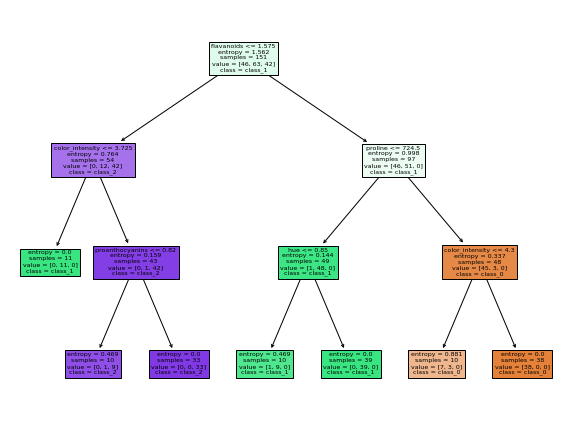

In [ ]:
# Include decision tree visualization here

fig = plt.figure(figsize=(10,7.5))
_ = tree.plot_tree(clf, 
                   feature_names=wine.feature_names,  
                   class_names=wine.target_names,
                   filled=True)

Using my best model, the tree split on Flavanoids <= 1.575. If is less than, it split on the color intensity. When the color intensity was less than 3.725, the output class was purely class 1.  When it was greater, it split once more. Both of the resulting classes were mostly class 2 so that was the prediction, but the confidence was much higher on the right node since it made up 33 samples rather than just 10 on the left.


## 4. (Optional 5% extra credit) Implement reduced error pruning to help avoid overfitting
- You will need to take a validation set out of your training data to do this, while still having a test set to test your final accuracy. 
- Create a table comparing your decision tree implementation's results on the cars and voting data sets with and without reduced error pruning. 
- This table should compare:
    - a) The # of nodes (including leaf nodes) and tree depth of the final decision trees 
    - b) The generalization (test set) accuracy. (For the unpruned 10-fold CV models, just use their average values in the table).

In [ ]:
# Reduced Error Pruning Code

Discussion